In [0]:
import matplotlib
#matplotlib.use('TkAgg')
import numpy as np
import pylab as plt

# Regresja nieliniowa za pomocą sieci neuronowej

W tym ćwiczeniu chcemy zastosować sieć do wykonania regresji nieliniowej. 

Załóżmy, że mamy generator który dostarcza żądaną ilość par liczb zgodnie z pewnym modelem, np.: 

In [0]:
def gen(ile, eps):
    x = np.sort(5*np.random.rand(ile))
    y = (1+10*x+x**2)/(1+2*x**2)
    y+= eps*y*np.random.randn(ile)
    return(x,y)


Niech generator dostarcza nam po N par liczb. Zobaczmy 5 realizacji. Zobaczmy dla jakiego N ta funkcja będzie spróbkowana 'rozsądnie'.

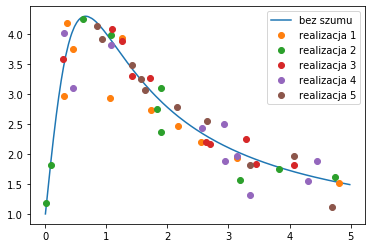

In [4]:
plt.figure()
X_idealne, Y_idealne = gen(ile=500, eps=0) # przykłady do ciągu uczącego    
l = plt.plot(X_idealne, Y_idealne,'-')

N=10
for i in range(5):
    X, Y = gen(ile=N, eps=0.1) # przykłady do ciągu uczącego    
    plt.plot(X, Y, 'o')
plt.legend(('bez szumu','realizacja 1','realizacja 2','realizacja 3','realizacja 4','realizacja 5'))
plt.show()

Proszę przygotować zbiór uczący zawierający 60 przykładów i testujący z 20 przykładami.

In [0]:
X, Y = gen(60, 0.1) # przykłady do ciągu uczącego
X_t, Y_t = gen(20, 0.1) # przykłady do ciągu monitorującego

Sklejamy te zbiory, aby skorzystać wprost z gotowej implementacji metody wczesnego stopu w keras [(link)](https://keras.io/getting-started/faq/#how-can-i-interrupt-training-when-the-validation-loss-isnt-decreasing-anymore). 

In [0]:
X1 = np.hstack((X,X_t))
Y1 = np.hstack((Y,Y_t))

* Proszę skonstruować sieć, którą można nauczyć zależności między punktami wejściowymi (x) i wyjściowymi (y). W tym celu najlepiej wykorzystać sieć z nieliniową warstwą ukrytą  i liniową warstwę wyjściową. Taka kombinacja warstw nieliniowej i liniowej pozwala na reprezentację dowolniej ciągłej funkcji, pod warunkiem użycia właściwej ilości neuronów w warstwie ukrytej. Liniowa warstwa wyjściowa pozwala na rozszerzenie zbioru wartości.

* Proszę wykreślić funkcję reprezentowaną przez sieć na tle punktów zbioru uczącego i prawdziwej (niezaszumionej) relacji ''y(x)''.

* Czy dla ustalonej architektury sieci (rozmiarów warstw) i ustalonego zbioru uczącego sieć zbiega do jednego rozwiązania? Dlaczego?
* Podobnie jak  w poprzednim zadaniu proszę zbadać ewolucję:
  * błędu na zbiorze uczącym
  * błędu na zbiorze monitorującym
  * Powyższe zależności proszę zaobserwować dla kilku rozmiarów warstwy ukrytej.

1. Nawet dla ustalonej architektury sieci i ustalonego zbioru uczącego sieć nie zbiega do jednego rozwiązania gdyż za każdym razem sieć jest inicjalizowana wartościami losowymi.
2. Błąd na zbiorze uczącym był wyższy lub równy błędowi na zbiorze monitorującym. Błąd zawsze na początku gwałtownie maleje a potem błędy się stabilizują przy czym mogą zbiec lub ustabilizować się na różnych poziomach. Mogą się też najpierw ustabilizować na różnych poziomach a po pewnej liczbie kroków zbiec (jak na dołączonym rysunku dla N=60 neuronów). Mamy więc wtedy gwałtowny spadek błędu na początku, potem stabilizację i zbiegnięcie obydwu błędów do wartości minimalnej. Za mała liczba neuronów ( np. N=2) nie pozwala na jakiekolwiek sensowne wytrenowanie sieci (dostajemy linię z grubsza poziomą). Dla N=8 można wytrenować sieć z małym błędem przy maksimum ("kolanko") lecz nachylenie linii opadającej (pod prawy koniec wykresu) jest błędne. Dla N=60 można dostać dobre dopasowanie. Im więcej neuronów tym pierwotna gwałtowna stabiizacja następuje szybciej.

In [117]:
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import RandomUniform
from keras.callbacks import EarlyStopping
from keras import regularizers

init = RandomUniform(minval=-0.2, maxval=0.2, seed=None)
model = Sequential()
model.add(Dense( 60, 
                input_dim= 1, 
                activation= 'sigmoid',
                kernel_initializer=init, 
                bias_initializer=init))

model.add(Dense(1,kernel_initializer=init, bias_initializer=init))# warstwa liniowa
model.summary()

from keras.optimizers import SGD, Adam
sgd = SGD(lr=0.01, decay=0, momentum=0.8, nesterov=True)
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', 
              optimizer= adam,
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=250)#patience: number of epochs with no improvement after which training will be stopped.
Historia = model.fit(X1, Y1, epochs=500, batch_size=10, verbose=0,shuffle=True, validation_split=20/80, callbacks=[early_stopping])#,tensorBoard ] )

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 60)                120       
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 61        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


### Wykresy

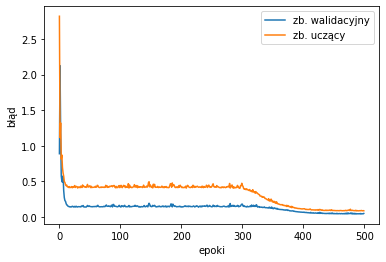

In [118]:
plt.figure()
plt.plot(Historia.history['val_loss'] )# na zbiorze walidacyjnym
plt.plot(Historia.history['loss'])# na zb. uczącym 
plt.legend(('zb. walidacyjny', 'zb. uczący'))
plt.xlabel('epoki')
plt.ylabel('błąd')
plt.show()

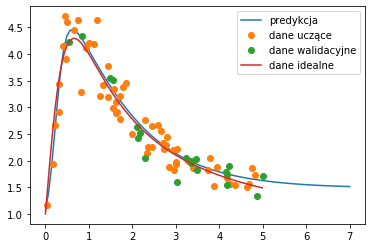

In [119]:
plt.figure()
x = np.linspace(0,7,100)
y_pred = model.predict(x)
plt.plot(x,y_pred)
plt.plot(X, Y, 'o')
plt.plot(X_t, Y_t, 'o')
plt.plot(X_idealne, Y_idealne,'-')
plt.legend(('predykcja','dane uczące','dane walidacyjne','dane idealne'))
plt.show()

## Analiza krzywych uczenia 
Na jakość regresji wpływ mogą mieć następujące czynniki:
* stopień skomplikowania wewnętrznej reprezentacji (tu: ilość jednostek ukrytych):
  * za dużo jednostek pozwala dobrze dopasować się do szczegółów w zbiorze uczącym, może jednak prowadzić do złej generalizacji
  * zbyt uboga reprezentacja (tu: za mało jednostek ukrytych) prowadzi do zbyt dużych błędów na obu zbiorach
* liczba przykładów w ciągu uczącym:
  * zbyt mała może powodować błędy generalizacji poprzez słabe pokrycie przestrzeni wejść
  * zbyt duża: niepotrzebnie podnosi czas uczenia i (w realnym świecie) koszty pozyskania przykładów
  
Oprócz wspomnianego już analizowania wykresów błędów na zbiorze treningowym i monitorującym pomocne może być przyjrzenie się wykresom błędów popełnianych na zbiorze uczącym i monitorującym w zależności od liczby przykładów w tych zbiorach.
* Dla kilku ustalonych architektur (możesz zmieniać liczbę jednostek ukrytych (np.: 2,8,60), liczbę warstw (spróbuj dodać jedną), funkcje aktywacji (np. sigmoid->relu)) zbadaj zależność błędu od rozmiaru zbioru uczącego.

Zbadano zależność błędu od rozmiaru zbioru uczącego dla 6-ciu architektur. Niech L - liczba warstw wewnętrznych, N - liczba neuronów w warstwie wewnętrznej (w każdej jest po N).
I.   L=1, sigmoid, N=2
II.  L=1, sigmoid, N=8
III. L=1, sigmoid, N=60
IV.  L=2, sigmoid, N=8
V.   L=1, relu, N=8
VI.  L=1, relu, N=8

W każdym przypadku zaobserwowano, że generalnie rozrzut błędu maleje wraz ze wzrostem rozmiaru zbioru uczącego a potem się stabilizuje. Wartości średnie błędu nie ulegają dużym zmianom.

### Inicjujemy stałe

In [0]:
N_epok = 1500 
rozmiary = np.arange(10, 121, 30, dtype = int)
N_rozmiarow = rozmiary.shape[0]
N_prob = 6

### Inicjujemy tablice na ewolucje błędów

In [0]:
bl = np.zeros((N_rozmiarow,N_prob)) #tablica na błąd zbioru uczącego
bl_val = np.zeros((N_rozmiarow,N_prob)) #tablica na błąd zbioru monitorującego

### Definiujemy  sieć:

In [0]:
model = Sequential()
model.add(Dense( 60, 
                input_dim= 1, 
                activation= 'relu', #relu
                kernel_initializer=init, 
                bias_initializer=init))

#model.add(Dense( 8, 
#                activation= 'sigmoid', #relu
#                kernel_initializer=init, 
#                bias_initializer=init))

model.add(Dense(1,kernel_initializer=init, bias_initializer=init))# warstwa liniowa
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', 
              optimizer= adam,
              metrics=['accuracy'])

### Uczymy sieć i zapisujemy błędy przy kolejnych rozmiarach zbioru uczącego

In [139]:
for i,N_przykladow in enumerate(rozmiary):
    print(' ')
    for proba in range(N_prob):
        print( 'test dla ', N_przykladow, 'przykładów; ''próba: ', proba)
        #zbiór uczący:
        X,   Y      = gen(N_przykladow,0.1) # przykłady do ciągu uczącego
        X_t, Y_t    = gen(N_przykladow,0.1) # przykłady do ciągu monitorującego
        H = model.fit(X, Y, epochs=N_epok, batch_size=10, verbose=0,shuffle=True)
        y_t = (1+10*X_t+X_t**2)/(1+2*X_t**2)
        bl_val[i,proba] = np.mean((y_t - model.predict(X_t))**2)#np.array(H.history['val_loss'])[-1]         
        y = (1+10*X+X**2)/(1+2*X**2)
        bl[i,proba] = np.mean((y - model.predict(X))**2)#np.array(H.history['loss'])[-1] 
     

 
test dla  10 przykładów; próba:  0
test dla  10 przykładów; próba:  1
test dla  10 przykładów; próba:  2
test dla  10 przykładów; próba:  3
test dla  10 przykładów; próba:  4
test dla  10 przykładów; próba:  5
 
test dla  40 przykładów; próba:  0
test dla  40 przykładów; próba:  1
test dla  40 przykładów; próba:  2
test dla  40 przykładów; próba:  3
test dla  40 przykładów; próba:  4
test dla  40 przykładów; próba:  5
 
test dla  70 przykładów; próba:  0
test dla  70 przykładów; próba:  1
test dla  70 przykładów; próba:  2
test dla  70 przykładów; próba:  3
test dla  70 przykładów; próba:  4
test dla  70 przykładów; próba:  5
 
test dla  100 przykładów; próba:  0
test dla  100 przykładów; próba:  1
test dla  100 przykładów; próba:  2
test dla  100 przykładów; próba:  3
test dla  100 przykładów; próba:  4
test dla  100 przykładów; próba:  5


## Rysunki

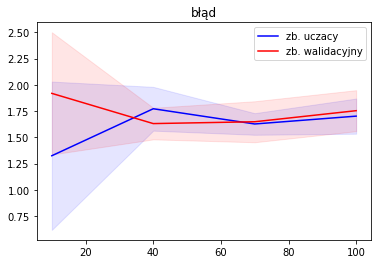

In [140]:
sr_bl = np.mean(bl, axis = 1)
std_bl = np.std(bl, axis = 1) 
sr_bl_val = np.mean(bl_val, axis = 1)
std_bl_val = np.std(bl_val, axis = 1) 
    
plt.figure()
plt.fill_between(rozmiary,sr_bl-std_bl,sr_bl+std_bl , alpha=0.1, color="b")
plt.plot(rozmiary,sr_bl, 'b',label='zb. uczacy')
plt.fill_between(rozmiary,sr_bl_val-std_bl_val,sr_bl_val+std_bl_val , alpha=0.1, color="r")
plt.plot(rozmiary,sr_bl_val, 'r',label='zb. walidacyjny')
plt.title(u'błąd')
plt.legend()
#plt.ylim([0,1.5])
plt.show()